In [1]:
import os
import random
import itertools
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, GaussianNoise, Activation, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2

from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [3]:
### DEFINE SOME PARAMETERS ###

base_path = '../../../dataset/dist-unbalanced'
SHAPE = (224,224,3)
batch_size = 128

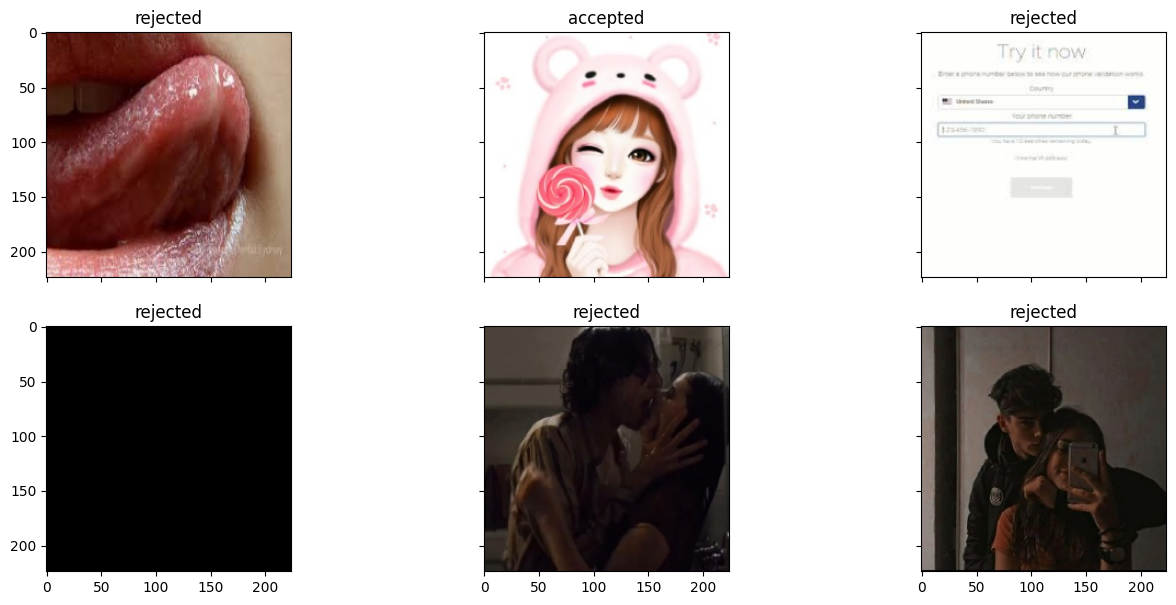

In [4]:
### PLOT SAMPLE IMAGES ###

f, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (16,7))

for ax in axes.ravel():
    label = np.random.choice(os.listdir(os.path.join(base_path , "train")))
    img = np.random.choice(os.listdir(os.path.join(base_path , "train" , label)))
    img = cv2.imread(os.path.join(base_path, "train", label, img))
    img = cv2.resize(img, SHAPE[:2])
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGRA2RGB))
    ax.set_title(label)
plt.show()

In [5]:
### GENERATOR WRAPPER TO CREATE FAKE LABEL ###

def wrap_generator(generator):
    
    while True:
        x,y = next(generator)
        y = tf.keras.utils.to_categorical(y)
        zeros = tf.zeros_like(y) + tf.constant([1.,0.])
        y = tf.concat([y,zeros], axis=0)
        
        yield x,y

In [6]:
@tf.keras.utils.register_keras_serializable()
class Preprocess(tf.keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        super(Preprocess, self).__init__(name=name)
        super(Preprocess, self).__init__(**kwargs)
        

    def call(self, inputs):
        return preprocess_input(inputs)
    
    def get_config(self):
        config = super(Preprocess, self).get_config()
        return config
    
@tf.keras.utils.register_keras_serializable()
class ZerosLike(tf.keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        super(ZerosLike, self).__init__(name=name)
        super(ZerosLike, self).__init__(**kwargs)
        

    def call(self, inputs):
        return tf.zeros_like(inputs)
    
    def get_config(self):
        config = super(ZerosLike, self).get_config()
        return config
    
@tf.keras.utils.register_keras_serializable()
class Concat(tf.keras.layers.Layer):
    def __init__(self,name=None, **kwargs):
        super(Concat, self).__init__(name=name)
        super(Concat, self).__init__(**kwargs)
        

    def call(self, inputs):
        return tf.concat(inputs, axis=0)
    
    def get_config(self):
        config = super(Concat, self).get_config()
        return config

In [7]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def get_model(train=True):
    
    set_seed(33)
    
    vgg = VGG16(weights = 'imagenet', include_top = True, input_shape = SHAPE)
    vgg = Model(vgg.input, vgg.layers[-3].output)
    vgg.trainable = False
    
    inp = Input(SHAPE)
    vgg_16_process = Preprocess()(GaussianNoise(0.1)(inp))
    vgg_out = vgg(vgg_16_process)
    
    noise = ZerosLike()(vgg_out)
    noise = GaussianNoise(0.1)(noise)

    if train:
        x = Concat()([vgg_out,noise])
        x = Activation('relu')(x)
    else:
        x = vgg_out
        
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(2, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(Adam(learning_rate=1e-4), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))
    
    return model

In [8]:
### CREATE EMPTY GENERATORS ###

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [9]:
### FLOW GENERATORS ###

train_generator = train_datagen.flow_from_directory(
            os.path.join(base_path, 'train'),
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            seed = 33,
            classes = ['rejected']
    )

test_generator = test_datagen.flow_from_directory(
            os.path.join(base_path , 'valid'),
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            seed = 33,
            classes = ['accepted','rejected']
)


Found 8528 images belonging to 1 classes.
Found 1090 images belonging to 2 classes.


In [10]:
es = EarlyStopping(monitor='val_loss', 
                   mode='auto', 
                   restore_best_weights=True, 
                   verbose=1, 
                   patience=5)

mc = tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/anomaly100e',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model = get_model()

model.fit(wrap_generator(train_generator),
          steps_per_epoch=train_generator.samples/train_generator.batch_size, 
          epochs=200)

Epoch 1/200


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


66/66 [==============================] - 44s 413ms/step - loss: 0.3973
Epoch 2/200
66/66 [==============================] - 19s 288ms/step - loss: 0.2957
Epoch 3/200
66/66 [==============================] - 20s 302ms/step - loss: 0.2146
Epoch 4/200
66/66 [==============================] - 20s 292ms/step - loss: 0.1340
Epoch 5/200
66/66 [==============================] - 19s 283ms/step - loss: 0.0846
Epoch 6/200
66/66 [==============================] - 19s 283ms/step - loss: 0.0539
Epoch 7/200
66/66 [==============================] - 19s 283ms/step - loss: 0.0326
Epoch 8/200
66/66 [==============================] - 19s 283ms/step - loss: 0.0238
Epoch 9/200
66/66 [==============================] - 19s 284ms/step - loss: 0.0166
Epoch 10/200
66/66 [==============================] - 19s 285ms/step - loss: 0.0120
Epoch 11/200
66/66 [==============================] - 19s 283ms/step - loss: 0.0102
Epoch 12/200
66/66 [==============================] - 19s 284ms/step - loss: 0.0076
Epoch 13/200


66/66 [==============================] - 19s 290ms/step - loss: 3.8492e-07
Epoch 188/200
66/66 [==============================] - 19s 288ms/step - loss: 3.6846e-07
Epoch 189/200
66/66 [==============================] - 19s 292ms/step - loss: 3.4886e-07
Epoch 190/200
66/66 [==============================] - 19s 288ms/step - loss: 3.4912e-07
Epoch 191/200
66/66 [==============================] - 19s 288ms/step - loss: 3.2586e-07
Epoch 192/200
66/66 [==============================] - 19s 288ms/step - loss: 3.1462e-07
Epoch 193/200
66/66 [==============================] - 19s 286ms/step - loss: 3.0203e-07
Epoch 194/200
66/66 [==============================] - 20s 293ms/step - loss: 2.9309e-07
Epoch 195/200
66/66 [==============================] - 19s 287ms/step - loss: 2.8323e-07
Epoch 196/200
66/66 [==============================] - 19s 286ms/step - loss: 2.7301e-07
Epoch 197/200
66/66 [==============================] - 19s 289ms/step - loss: 2.6036e-07
Epoch 198/200
66/66 [==============

In [11]:
model.save('./models/one_class.h5')

In [12]:
loaded_model = tf.keras.models.load_model('./models/one_class.h5', 
                                          custom_objects={
                                         "Preprocess":Preprocess,
                                         "ZerosLike":ZerosLike,
                                         "Concat":Concat
                                          })

In [13]:
# from keras import backend as K
# K.clear_session()

In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 224, 224, 3)  0          ['input_2[0][0]']                
                                                                                                  
 preprocess_1 (Preprocess)      (None, 224, 224, 3)  0           ['gaussian_noise[0][0]']         
                                                                                                  
 model (Functional)             (None, 4096)         117479232   ['preprocess_1[0][0]']     

In [15]:
### RETRIVE TEST LABEL FROM GENERATOR ###

test_num = test_generator.samples

label_test = []
for i in range((test_num // test_generator.batch_size)+1):
    X,y = test_generator.next()
    label_test.append(y)
        
label_test = np.argmax(np.vstack(label_test), axis=1)
label_test.shape

(1090,)

In [16]:
### SWITCH TO INFERENCE MODE TO COMPUTE PREDICTIONS ###

ineference_model = get_model(train=False)
ineference_model.set_weights(loaded_model.get_weights())

In [17]:
### COMPUTE PREDICTIONS ON TEST DATA ###

pred_test = np.argmax(ineference_model.predict(test_generator), axis=1)

9/9 [==============================] - 10s 1s/step


In [18]:
### ACCURACY ON TEST DATA ###

print('ACCURACY:', accuracy_score(label_test, pred_test))

ACCURACY: 0.5577981651376147


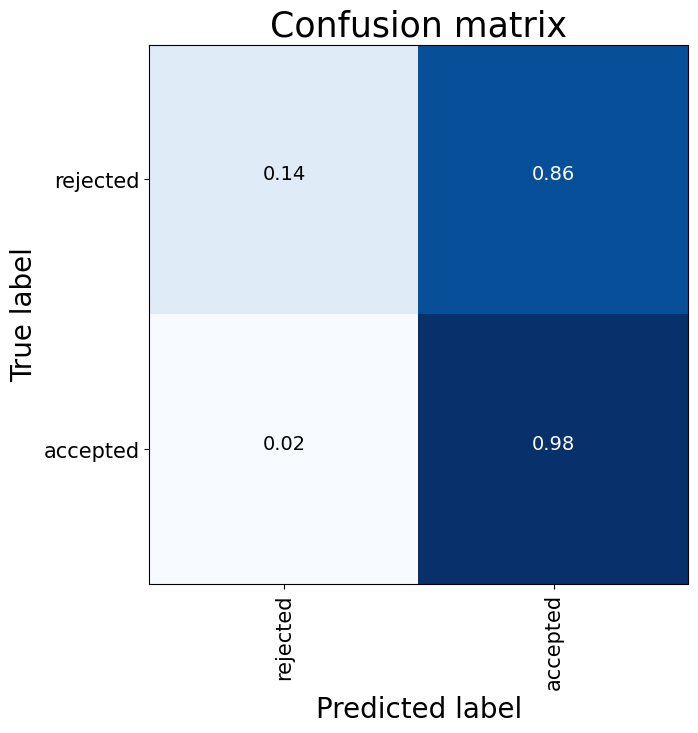

In [19]:
### CONFUSION MATRIX ON TEST DATA ###

cnf_matrix = confusion_matrix(label_test, pred_test)

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=['rejected','accepted'])
plt.show()